# Overview
The Raspiscope takes colour images of fluorescence in multiple channels. We can use the scope to take time-lapse image series (like videos) of bacterial colonies, to see how they grow and synthesise fluorescent proteins. The first step in analysing the behaviour of these colonies is to locate the colonies in the images and measure their size. Next we need to compute their level of fluorescence. We do this in each image in the series to form time-varying signals for each colony. 

## Open source Python packages
We will use some excellent open source packages to do our analysis. First, numpy is a package to do numerical computing including handling arrays:

In [1]:
import numpy as np

Matplotlib is a package (that contains a sub-package called PyPlot) for plotting graphs, charts, images and other graphics: 

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

Scikit-image is an image processing and machinge vision package, we will use it to do object recognition to find colonies in images:

In [3]:
import skimage 
from skimage import io, filters

## Loading image data

First lets define the location where the images are stored. You should download the example image data from the GoogleDrive (https://goo.gl/Trg1DX) and put the path in the string below, following this example:

In [11]:
# The folder where the file is:
fpath =  "TLE_G_7_3_17"
# The pattern of the file names:
fpattern = "image_%04d.jpg"

# Here we use the python function join to add the folder and file name.
# [This is because different operating systems (e.g. Windows, Mac OSX)
# use different symbols to separate file paths]
import os
fname = os.path.join(fpath, fpattern)
print(fname%(0))   # print to see if names are well defined

TLE_G_7_3_17/image_0000.jpg


Note how the % notations adds a number to the string, so we can specify which image to load.

### Image data structure

We will use PyPlot function *imread* to read the file into a numpy array. This is a 3-dimensional array (a grid of values) with dimensions x,y,c, with (x,y) position and c the color channel (red, green, blue). 

<img src="files/imagearray.png" width=256 height=256>

Let's try this with the frame 500 image:

In [13]:
im300 = plt.imread(fname%300)

We can use PyPlot again to display the array (*imshow*), which correctly interprets the array as a color image:

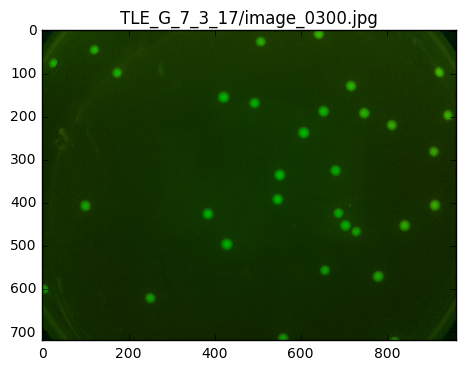

In [14]:
plt.figure()
plt.imshow(im300)
plt.title(fname%300)

Or we can show channels separately 

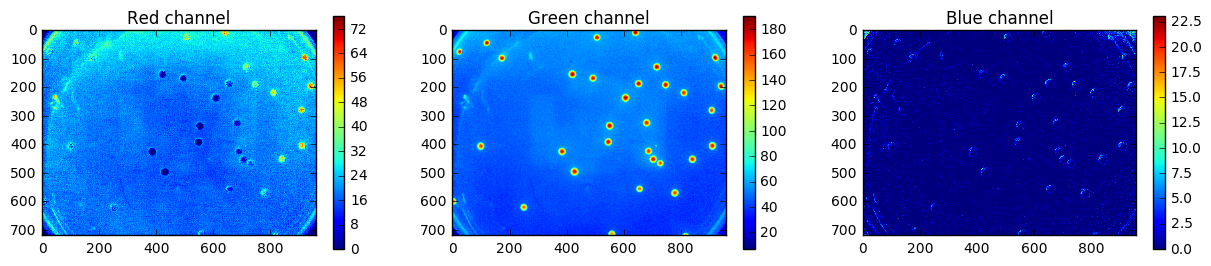

In [15]:
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.imshow(im300[:,:,0])
plt.colorbar()
plt.title('Red channel')

plt.subplot(132)
plt.imshow(im300[:,:,1])
plt.colorbar()
plt.title('Green channel')

plt.subplot(133)
plt.imshow(im300[:,:,2])
plt.colorbar()
plt.title('Blue channel')

Each pixel of each channel can take a value between 0 to 255, which value is indicated accord the colorbar at the side of each plot.


### Loading the time series images
There are 3 channels in each image (R,G,B). 
We will load each channel of all the images into a 3-dimensional array, with dimensions x, y, time. 

<img src="files/TempMatrix.png" width=800 height=256>

We need to know the **size of each image**. We can get it from the numpy array shape. The 3rd dimension size is 3 for the color channels R,G,B --> We dont need it, so use the dummy "_" variable.

In [17]:
w,h,_ = im300.shape
print('w = %d, h = %d'%(w,h))

w = 720, h = 960


Now we create a numpy array to hold the data and loop over the files, taking only channel 1 (green). There are a lot of time points in this series, so here we take every 10th frame:

In [19]:
# Number of images to load
nt = 30
# Take every 10th frame
xframes = 10

# Create one array for each channel R,G,B
imsR = np.zeros((w,h,nt))
imsG = np.zeros((w,h,nt))
imsB = np.zeros((w,h,nt))

# Loop over the image files and put the data in the arrays
for i in range(0,nt):
    im = plt.imread(fname%(i*xframes))
    imsR[:,:,i] = im[:,:,0]
    imsG[:,:,i] = im[:,:,1]
    imsB[:,:,i] = im[:,:,2]

## Analysis of time-lapse images
Now we have all the data loaded into a numpy arrays. There are 3 channels, but for simplicity here we will only consider the green (G) channel. To speed things up, take a subregion of the image to analyse. We do this by '[slicing](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html)' the array:

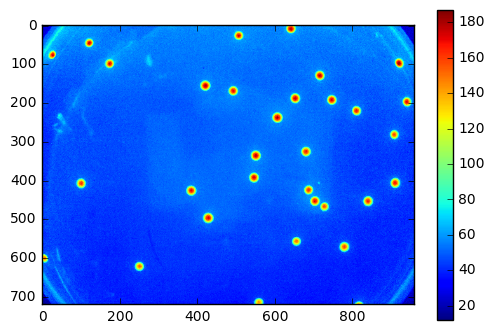

In [45]:
imssub = imsG#[300:700,200:600,:]
plt.imshow(imssub[:,:,-1])
plt.colorbar()

### Mean dynamics over image domain
We can get some information by looking just at the variation in total image intensity in the time-series. Do this by taking the sum of the (x,y,t) stack over the first two dimensions (0,1):

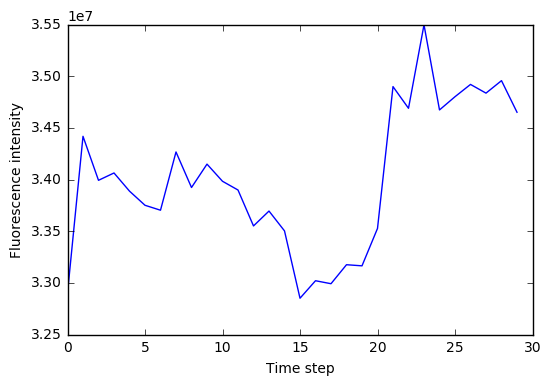

In [27]:
sumims = imssub.sum(axis=(0,1))
plt.plot(sumims)
plt.xlabel('Time step')
plt.ylabel('Fluorescence intensity')

### Identifying colonies
#### Pre-processing
The colonies vary in brightness over the experiment but do not move. So we can take the sum of intensity of each pixel over time, and use it to locate colonies reliably:

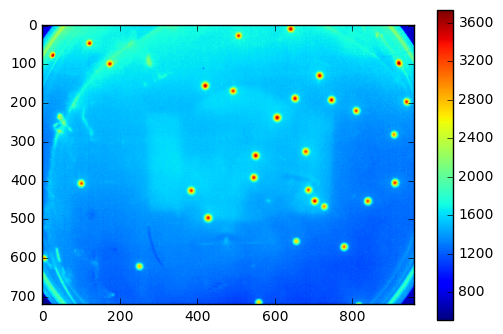

In [32]:
ims_sum = imssub.sum(axis=2)
plt.imshow(ims_sum)
plt.colorbar()

With any image its essential to remove noise before analysis, here with a [Gaussian filter](http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian). Normalisation by scaling the image to (0,1) is also convenient:

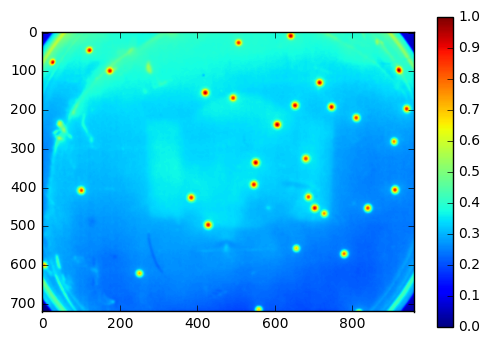

In [33]:
from skimage.filters import gaussian
simsub = gaussian(ims_sum, 2)
nsimsub = (simsub-simsub.min())/(simsub.max()-simsub.min())

# Plot the result
plt.imshow(nsimsub)
plt.colorbar()

#### Blob detection
Scikit-image provides several functions to detect Gaussian-like features ([blobs](http://scikit-image.org/docs/dev/auto_examples/plot_blob.html)). We apply one of these ([blob_log](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log)) to the smoothed sum of intensity, and it returns a list of position (x,y) and width (standard deviation):

In [34]:
import skimage.feature as skfeat
A = skfeat.blob_log(nsimsub, min_sigma=1.0, max_sigma=10.0, num_sigma=100, threshold=0.25, overlap=0.8)

# Print some of the results
print (A.shape)
print (A[0:4,:])

(26, 3)
[[  12.          640.            5.72727273]
 [  49.          122.            5.36363636]
 [  80.           27.            4.81818182]
 [ 100.          918.            5.81818182]]


The array A now contains the location (x,y) and size of probable colonies. The size is the standard deviation of the Gaussian blob, which we assume to be roughly 1/2 the radius. We can check by showing the image and plotting circles on top at each location contained in A:

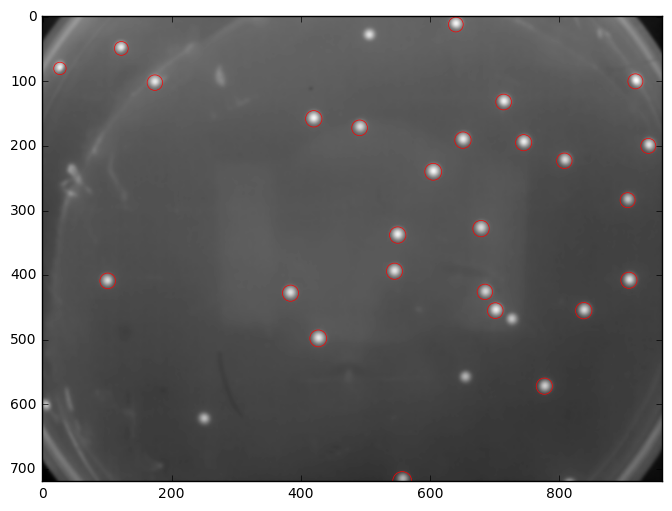

In [35]:
plt.figure(figsize=(8,8))
plt.imshow(nsimsub, cmap='gray')
plt.hold(True)
for i in range(len(A)):
    circle = plt.Circle((A[i,1], A[i,0]), 2*A[i,2], color='r', fill=False , lw=0.5)
    fig = plt.gcf()
    ax = fig.gca()
    ax.add_artist(circle)

### Time dynamics of colonies
Now we have estimated colony location (and size) we can analyse the dynamics of fluorescence and growth. 

To restrict image analysis for each colony, we can extract a region at each location, with size given by the Gaussian width (x2 = 2 standard deviations). Here we put the image series into a dictionary indexed by colony. 

In [36]:
rois = {}
for i in range(len(A)):
    x = A[i,0]
    y = A[i,1]
    r = 2*A[i,2]
    rois[i] = imssub[x-r:x+r,y-r:y+r,:]

/Users/timrudge/miniconda/envs/raspiscope/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


#### Colony total fluorescence 
Now we can plot the total fluoresence in the region of each colony:

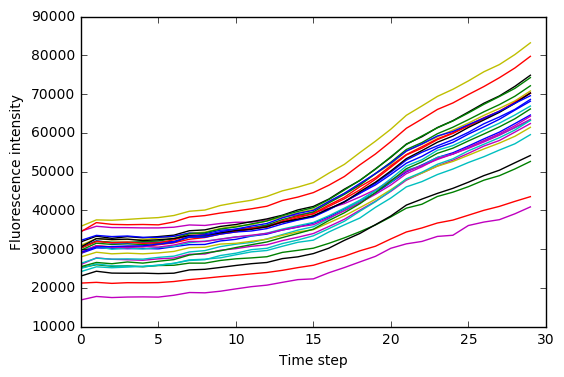

In [37]:
for i in range(len(A)):
    plt.plot(rois[i].sum(axis=(0,1)))
    plt.hold(True)
plt.xlabel('Time step')
plt.ylabel('Fluorescence intensity')

#### Colony radius growth
We have the location and some kind of size estimate based on the total fluorescence of each colony over the time-lapse. We would like to know the size of the colony in each frame; from this we can compute the growth rate.

One way to do this is the find Gaussian blobs in each of the image regions of the colony, for each frame of the time-lapse. Then assume that the first (only?) blob detected is the colony we are interested in. 

The following loop finds blobs and stores the width in each frame. The result is a dictionary containing the size at each time point for every colony.

In [38]:
R = {}
for k in range(len(A)):
    R[k] = np.zeros((nt,))
    for i in range(nt):
        troi = rois[k][:,:,i].astype(np.float32)
        if len(troi):
            ntroi = (troi-troi.min())/(troi.max()-troi.min())
            AA = skfeat.blob_log(ntroi, min_sigma=1.0, max_sigma=10.0, num_sigma=200, threshold=0.25, overlap=0.8)
            if len(AA)>0:
                R[k][i] = 2*AA[0,2]

Since the colony is roughly circular and flat, an estimate of volume is $R^2$. Lets plot this for some colonies. Plotting the log is useful because the slope is the relative growth rate. We can see the colonies slow their growth during the experiment.

/Users/timrudge/miniconda/envs/raspiscope/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


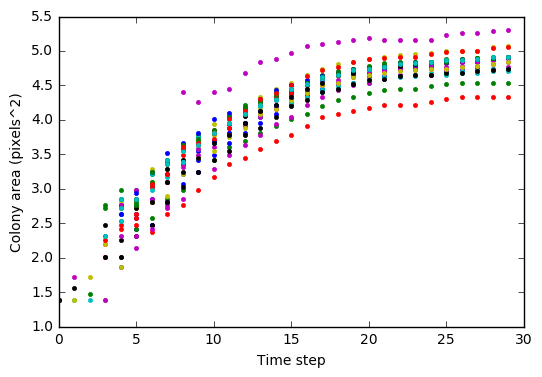

In [43]:
for i in range(len(A)):
    r = R[i]
    plt.plot(np.log(r*r), '.')
    plt.hold(True)
    
plt.xlabel('Time step')
plt.ylabel('Colony area (pixels^2)')

To see how well the colony size is estimated, we can compare to the profile of a colony in a slice of its image region. The radius (red line) should give the border of the colony.

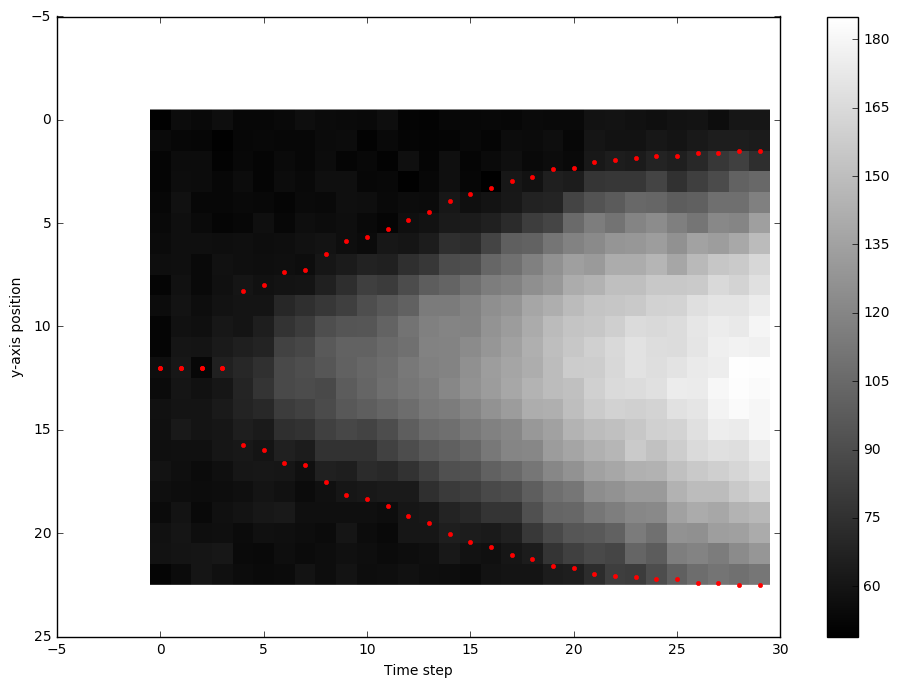

In [47]:
# Specify index of colony to plot
idx = 3

# Size of image data
w,h,d = rois[idx].shape

plt.figure(figsize=(12,8))

# Plot the image data
plt.imshow(rois[idx][w/2+1,:,:], interpolation='none', cmap='gray')
plt.colorbar()
plt.hold(True)

# Plot the radius estimate
plt.plot(-R[idx]+h/2+1,'r.')
plt.plot(R[idx]+h/2+1,'r.')

plt.xlabel('Time step')
plt.ylabel('y-axis position')

Notice that early in the experiment, time steps 0-3, the radius is estimated as zero because the colony is not visible to the camera. The more advanced example notebooks deal with this by fitting a growth curve to the estimated radius.